# Exergy efficiency

This script performs a simple calculation of the exergy efficiency for a 1-D storage in order to provide a deeper understaning on how to assess stratification of a storage using the exergy efficiency.

The method applied is described in the publication by Haller M. Y. (2010), "A method to determine stratification efficiency of thermal energy storage processes independently from storage heat losses".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from temperature_profile import temp_profile
from matplotlib import animation
from matplotlib.animation import FuncAnimation

Enter the simulation settings.

In [2]:
# Water proprties
density_water = 980 # in kg/m3
specific_heat_water = 4200  # in J/(kg K)

# Simulation properties
simulated_case = '' # Set the case that will be simulated, e.g. "fully_mixed", "fully_stratified". Otherwise, it simulates storage operation with mixing based on mixing_nodes.
heat_loss_coeff = 6 # in W/(m^2 K). This number gives a 90% storage efficiency for the selected settings. Set to 0 for no heat loss.

N = 60 # number of tank nodes
mix_nodes = int(N/10) # number of nodes close to the inlet that are mixed for imitating inlet jet mixing. Has to be integer!!!

T_hot = 90 # charge temperature
T_cold = 45 # discharge temperature
T_threshold = 10 # temperature threshold for considering the tank full/empty. E.g. if it is 10 degC then the tank is fully when the bottom is at 80 degC
T_amb = 10 # ambient temperature for calculatio of heat losses

th_cond_coeff = 2.5 # effective vertical thermal conductivity coefficient in W/(m K)
simulation_period = 1500 # This period is overwritten based on the maximum number of cycles set below. Has to be a large number!!
max_storage_cycles = 2 # stops the simulation after a number of charge-discharge cyles

timestep_duration = 3600/N # timestep duration in [s]

plot = False # Plots the temperature profile in the tank

# Storage properties
storage_height = 1 # the height of storage in m
storage_volume = 1 # the volume of storage in m^3
volume_per_layer = 1/N # assuming that the storage is 1-D
mass_per_layer = density_water * volume_per_layer # mass per layer
storage_mass = density_water * storage_volume # total storage mass
storage_area = 6 * storage_height**2 # in m2. Assuming that the storage is a cube

Create dataframe containing the temperature profiles for each time step. Rows are the simulation time steps and columns are the layers of the storage starting from the top (0) to the bottom (N).

The "df_ancil" is a dataframe that contains the calculated heat loss entropy, storage entropy, heat loss (energy), energy rate, energy content, and charge status.

In [3]:
df, df_ancil = temp_profile(simulated_case, N, mix_nodes, T_hot, T_cold, T_threshold, th_cond_coeff, simulation_period,
                            heat_loss_coeff, plot=plot, max_storage_cycles=max_storage_cycles, T_amb=T_amb)

Plot the storage temperatrue profile over time for inspection. Instead of plotting the temperature of each node, every 5th node is plotted for better visualization.

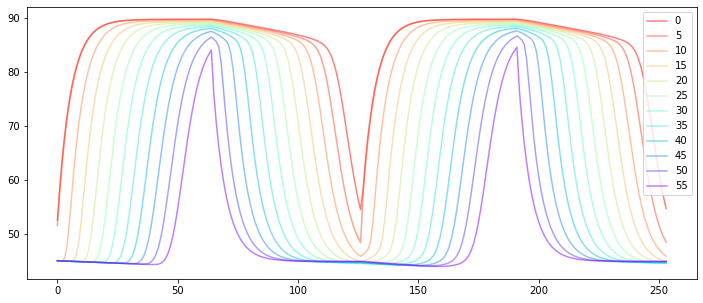

In [4]:
_ = df[np.arange(0,df.shape[1],5)].plot(cmap='rainbow_r', alpha=0.5, figsize=(12,5))

It is probalby not correct to use the entropy function (e.g. from engineering toolbox) for finding the entropy of the storage. The reason is that this function assumes zero entropy for water at 0 $^oC$ but the storage is considered empty when the temperature is 45 $^oC$. Although from a physics point of view this is correct (water has entropy in temperatures higher than $0 ^oC$), regarding the storage operation it gives a paradox, since the storage is considered empty regarding energy but still has an entropy content! 

It is probalby better to calculate the entropy of the storage using the expression: $$\Delta S = \frac{\Delta Q}{T}$$

This way there is an agreement between the storage energy and entropy content.

The same method should be followed for the entropy flows in/out of the storage. Haller suggests to calculate them using a standard entropy equation. However, this way, if the storage is at $50 ^oC$ and the inlet temperature is at the same temperature, there will be higher entropy in the flow thant in the storage. For this reason, also for the flows, the above formula is recommended.

In the end, all of the storage's entropies (storage, flows and heat loss) will be calculated using the same formula so at least the calculation will be consistent!

Then for calculating the exergy, the following general expression will be used: $$ \Delta Ex = \Delta H - T_{0} \cdot \Delta S $$

For the exergy efficiency, the internally generated exergy in the storage has to be divided with the internally generated exergy of a reference storage that is considered fully mixed during the entire charge/discharge operation:

$$\eta_{Ex} = 1 - \frac{\Delta Ex_{exp,int}}{\Delta Ex_{mix,int}}$$

Where:
$$\Delta Ex_{int} = \Delta Ex_{storage} - \Delta Ex_{inlet} + \Delta Ex_{outlet} + \Delta Ex_{heat loss}$$

This exergy balance is derrived from the general expression:
$$Ex_{input} - Ex_{consumption} - Ex_{output} = Ex_{accumulation}$$

Considerations:
* The mixed storage exergy should be lower than the stratified.
* Since the storage is an open system (heat and mass can flow through it) the storage exergy can be increased and decreased (but cannot be negative).
* Both the $Ex_{exp,int}$ and the $Ex_{mix,int}$ should be negative since it is exergy destruction by mixing, heat conduction and heat diffusion.

If the system reaches a state which is in equilibrium with its surroundings, then the system can not exchanges work, heat, and mass with its surroundings. This state is called a thermodynamic dead state. For this reason, the thermodynamic dead state temperature $T_{0}$ has to be set equal to the ambient temperature.

Calculation of exergies for the experimental storage. First the inlet and outlet temperatures are defined and then exergies are calculated for the flow, storage, heat loss and internally generated.

In [5]:
# weighted average temparature of the storage at each timestep
T_avg = (df*mass_per_layer/storage_mass).sum(axis=1)

# Thermodynamic dead state for exergy calculation [K]
T_0 = T_cold + 273.15

# Flows in [m3]
flow_in = volume_per_layer
flow_out = volume_per_layer

# Calculation of inlet and outlet temperature for charge and discharge [C]
T_input = []
T_output = []

for i in df.index:
    if df_ancil['charge_status'][i]==1:
        T_i = T_hot
        T_o = df.loc[i,N-1]
        T_input.append(T_i)
        T_output.append(T_o)
    else:
        T_i = T_cold
        T_o = df.loc[i,0]
        T_input.append(T_i)
        T_output.append(T_o)

T_in = pd.Series(T_input)
T_out = pd.Series(T_output)


# Enthalpy in and out of the storage [J]
H_exp_in = flow_in * density_water * specific_heat_water * (T_in - T_cold)
H_exp_out = flow_out * density_water * specific_heat_water * (T_out - T_cold)

# The calculated enthalpy of the storage is identical to the df_ancil['energy_content'], units in [J]
H_exp_accumulated = df_ancil['energy_content']

# The enthalpy of the flows and heat loss are time dependent with a time step of 1, so this is why cumsum is used
H_exp_flow = (H_exp_in-H_exp_out).cumsum() # [J]
H_exp_heat_loss = -df_ancil['heat_loss'].cumsum() # [J]


# Entropy in and out of the storage [J/K]
S_exp_in = (flow_in * density_water * specific_heat_water * (T_in - T_cold))/(T_in + 273.15)
S_exp_out = (flow_out * density_water * specific_heat_water * (T_out - T_cold))/(T_out + 273.15)

# The calculated Q_store is identical to the df_ancil['energy_content'], units in [J/K]
S_exp_accumulated = df_ancil['storage_entropy']

# The entropy flow and heat loss are time dependent and time integrated according to Haller's method, so this is why cumsum is used
S_exp_flow = (S_exp_in-S_exp_out).cumsum() # [J/K]
S_exp_heat_loss = df_ancil['heat_loss_entropy'].cumsum() # [J/K]


# Exergy calculations [J]
Ex_exp_flow = H_exp_flow - T_0 * S_exp_flow
Ex_exp_accumulated = H_exp_accumulated - T_0 * S_exp_accumulated
Ex_exp_heat_loss = H_exp_heat_loss - T_0 * S_exp_heat_loss

# Internal exergy destruction calculation [J]
Ex_exp_internal = Ex_exp_accumulated - Ex_exp_flow - Ex_exp_heat_loss

Plot of the calcuated exergies for the investigated storage.

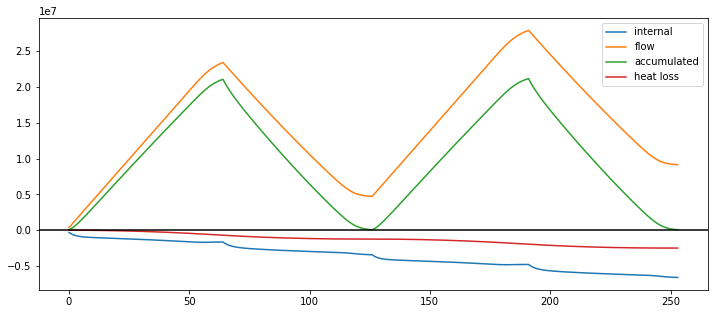

In [6]:
plt.figure(figsize=(12,5))
Ex_exp_internal.plot(label='internal')
Ex_exp_flow.plot(label='flow')
Ex_exp_accumulated.plot(label='accumulated')
Ex_exp_heat_loss.plot(label='heat loss')
plt.legend()
plt.axhline(0, c='k')

For time periods with constant charging or discharging mass flow and inlet temperature, the temperature of the fully mixed reference storage at time $t_{B}$ is calculated from the temperature at the begining of this period $T_{store,mix}(t_{A})$, the temperature that would be reached after infinite time $T_{inf}$, and the time constant of the process $a$.

$$ T_{out,mix}(t_{B}) = T_{inf} + [T_{store,mix}(t_{A}) - T_{inf}] \cdot exp(-a \cdot [t_{B}-t_{A}]) $$

With:

$$ T_{inf} = \frac{UA \cdot T_{amb} + C_{flow} \cdot T_{inlet}}{UA + C_{flow}} $$

$$ a = \frac{UA + C_{flow}}{C_{store}} $$

Where $C_{flow}$ is the capacity flow rate of the charging or discharging process and $C_{store}$ is the thermal capacitance of the storage.

$$ C_{flow} = \frac{H(T_{out}) - H(T_{inlet})}{T_{out} - T_{inlet}} $$

Where $h$ is the enthalpy in $J$.

The fully mixed reference storage is assumed to be equal to the experimental at the begining of the experiment and fully mixed from this point until the end of the experiment. Further, the fully mixed reference storage has the same heat loss coefficients as the experimental storage and is subjected to the same mass flows and temperatures. The temperature of the fully mixed reference storage is at the same time its outlet temperature.

In [7]:
# Specific enthalpy in and out of the storage [J/kg]
h_exp_in = specific_heat_water * (T_in - T_cold)
h_exp_out = specific_heat_water * (T_out - T_cold)

# Capacity flow rate of charge/discharge [W/K]
C_flow = (h_exp_out - h_exp_in).divide(T_out - T_in).multiply(flow_in*density_water).divide(timestep_duration)

# Thermal capacitance of storage [J/K]
C_store = specific_heat_water * storage_mass

# Time constant [s^-1]. Heat loss coefficient has to be converted to [W/K] in order for the time constant to have units of [s^-1]
a = (heat_loss_coeff * storage_area + C_flow)/C_store

# Temperature of storage that would be reached after infinite time [C]
T_inf = ((heat_loss_coeff*storage_area*(T_amb+273.15) + C_flow*(T_in+273.15))/(heat_loss_coeff*storage_area + C_flow))-273.15

# Outlet temperature of the fully mixed storage [C]
T_out_mix = []

# list with the timesteps where the 'charge_status' changes
change_operation = df_ancil['charge_status'][df_ancil['charge_status'].diff() != 0].index.tolist()

# Empty list for adding the outlet temperatures for the fully mixed storage
T_out_m = []

# Iterative calculation for the outlet temperature of the fully mixed storage [C]
for i in df.index:
    if i in change_operation:
        pos = i
        
    if i < change_operation[1]:
        # the fully mixed storage starts with the same temperature profile as the actual storage
        T_o_m = T_inf[i] + ((df.loc[0]*mass_per_layer/storage_mass).sum() - T_inf[i]) * np.exp(-a*(i-pos)*timestep_duration)[i]
        T_out_m.append(T_o_m)
    else:
        T_o_m = T_inf[i] + (T_out_m[pos-1] - T_inf[i]) * np.exp(-a*(i-pos)*timestep_duration)[i]
        T_out_m.append(T_o_m)
            
T_out_mix = pd.Series(T_out_m)

# The temperature of the mixed storage is equal to the outlet temperature [C]
T_store_mix = T_out_mix

Inspection of the calculated mixed storage output temperature compared to the average temperatrue of the experimental storage and the inifinite temperatrue of the fully mixed storage.

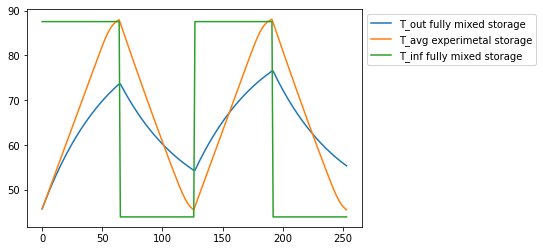

In [8]:
plt.figure()
T_out_mix.plot(label='T_out fully mixed storage')
T_avg.plot(label='T_avg experimetal storage')
T_inf.plot(label='T_inf fully mixed storage')
plt.legend(bbox_to_anchor=(1,1))

Exergy calculation for the fully mixed storage

In [9]:
# Enthalpy in and out of the fully mixed storage [J]
H_mix_in = flow_in * density_water * specific_heat_water * (T_in - T_cold)
H_mix_out = flow_out * density_water * specific_heat_water * (T_out_mix - T_cold)

# Accumulated enthalpy in the storage [J]
H_mix_accumulated = storage_volume * density_water * specific_heat_water * (T_store_mix - T_cold)

# The enthalpy of the flows and heat loss are time dependent with a time step of 1, so this is why cumsum is used
H_mix_flow = (H_mix_in-H_mix_out).cumsum() # [J]
H_mix_heat_loss = (heat_loss_coeff * storage_area * timestep_duration*(T_store_mix - T_amb)).cumsum() # [J]


# Entropy in and out of the storage [J/K]
S_mix_in = (flow_in * density_water * specific_heat_water * (T_in - T_cold))/(T_in + 273.15)
S_mix_out = (flow_out * density_water * specific_heat_water * (T_out_mix - T_cold))/(T_out_mix + 273.15)

# Accumulated entropy in the storage [J/K]
S_mix_accumulated = (storage_volume * density_water * specific_heat_water * (T_store_mix - T_cold))/(T_store_mix+273.15)

# The entropy flow and heat loss are time dependent so this is why sumsum is used
S_mix_flow = (S_mix_in-S_mix_out).cumsum() # [J/K]
S_mix_heat_loss = (heat_loss_coeff * storage_area * timestep_duration* (T_store_mix - T_amb) / (T_store_mix+273.15)).cumsum()


# Exergy calculations [J]
Ex_mix_flow = H_mix_flow - T_0 * S_mix_flow
Ex_mix_accumulated = H_mix_accumulated - T_0 * S_mix_accumulated
Ex_mix_heat_loss = -(H_mix_heat_loss - T_0 * S_mix_heat_loss)

Ex_mix_internal = Ex_mix_accumulated - Ex_mix_flow - Ex_mix_heat_loss

Plot of the calculated exergies for the fully mixed storage.

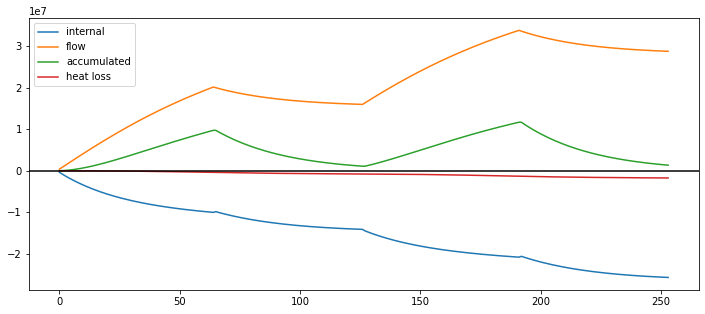

In [10]:
plt.figure(figsize=(12,5))
Ex_mix_internal.plot(label='internal')
Ex_mix_flow.plot(label='flow')
Ex_mix_accumulated.plot(label='accumulated')
Ex_mix_heat_loss.plot(label='heat loss')
plt.legend()
plt.axhline(0, c='k')

(0.0, 105.0)

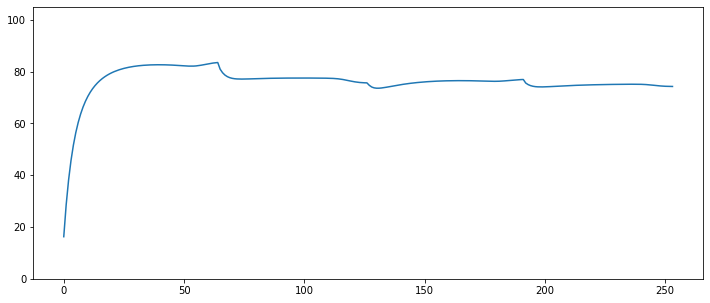

In [11]:
Ex_eff = (1 - Ex_exp_internal/Ex_mix_internal)*100

plt.figure(figsize=(12,5))
Ex_eff.plot()
plt.ylim(0,105)

## Overall Exergy efficiency

The overall exergy efficiency of the storage can be found by dividing the exergy output of the storage with the exergy inout:
$$ \eta_{Ex} = \frac{Ex_{out}}{Ex_{in}} $$

A different expression can also be used for exergy: $$ Ex = Q \cdot \left( 1 - \frac{T_{amb}}{T} \right) $$

Where $Q$ is the energy flowing in/out and $T$ is the temperature at which the energy flow occurs.

In [12]:
# These expressions give the same results with: H - T_0 * S
Ex_exp_in = H_exp_in * (1 - ((T_amb+273.15)/(T_in+273.15)))
Ex_exp_out = H_exp_out * (1 - ((T_amb+273.15)/(T_out+273.15)))

Ex_eff_overall = Ex_exp_out.sum()/Ex_exp_in.sum()

print(f'The overall exergy efficiency is: {round(Ex_eff_overall,3)*100}%')

The overall exergy efficiency is: 86.6%


In [13]:
Q_exp_in = flow_in * density_water * specific_heat_water * (T_in - T_cold)
Q_exp_out = flow_out * density_water * specific_heat_water * (T_out - T_cold)

Q_eff_overall = Q_exp_out.sum()/Q_exp_in.sum()
print(f'The overall energy efficiency is: {round(Q_eff_overall,3)*100}%')

The overall energy efficiency is: 91.7%
